# Classification Model

Do aspects of congress members tell us how how their stocks will do in comparison to the S&P 500? Are there features we can use to watch for whether a congress member will do unusually well?  

We are looking into feature importances of our model specifically in order to see the performance. it would also be useful in order to understand how much of what the STOCK Act tells us can be used to monitor congress members' stock performances. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#setting up random seed for project requirements 
np.random.seed(73)

In [3]:
# New
#reading in final dataset from EDA 
df = pd.read_csv('./data/stock_percentage_difference.csv')
df['total_raised'] =[int(raised.replace('$','')) for raised in df['total_raised']]
df['percent_from_small_donors*'] = [float(pct.replace('%','')) for pct in df['percent_from_small_donors*']]

In [4]:
beats_sp = []
for i, row in df.iterrows():
    if (row['day_180_stock_perc_diff']-row['day_30_stock_perc_diff'])\
    > (row['sp_180_sp_perc_diff'] - row['sp_30_sp_perc_diff']):
        beats_sp.append(1)
    else:
        beats_sp.append(0)
df['beats_sp'] = beats_sp

df = df.loc[df['type'] == 'purchase']

In [5]:
#baseline
df['beats_sp'].mean()

Features = ['party_x', 'total_senate_years', 'total_house_years', 'total_raised',
            'percent_from_small_donors*', 'amount']
X = df[Features]
y = df['beats_sp']
X = pd.get_dummies(X, columns = ['party_x', 'amount'], drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [6]:
# Voting Regressor
# pick and choose here which combinations to try for best model 
vote = VotingClassifier([
#    ('logreg', LogisticRegression()),
    ('rfc', RandomForestClassifier()),
    ('extatrees', ExtraTreesClassifier()),
    ('bag', BaggingClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
], voting='soft')
grid_params = {
#    'logreg__penalty': ['l1', 'l2'],
#    'logreg__C': [0.1, 1], 
#    'logreg__solver': ['saga'],
#    'logreg__warm_start': [False, True],
    'rfc__n_estimators': [100],
    'rfc__max_depth': [10],
    'bag__n_estimators': [10],
    'bag__max_samples': [1.0],
    'extatrees__n_estimators': [150],
    'extatrees__min_samples_split': [2, 1],
    'gb__learning_rate': [.1],
    'gb__n_estimators': [50],
#    'gb__base_estimator': ['DecisionTreeClassifier', 'RandomForestClassifier'],
    'ada__n_estimators': [10],
    'ada__learning_rate': [.1],
#    'ada__base_estimator': ['DecisionTreeClassifier', 'RandomForestClassifier']
}

vote = GridSearchCV(vote, grid_params, cv=5, n_jobs = -1)
vote.fit(X_train_sc, y_train)
vote.best_score_

0.5432679738562092

Training Score: 0.5866666666666667
Testing Score: 0.5556426332288401


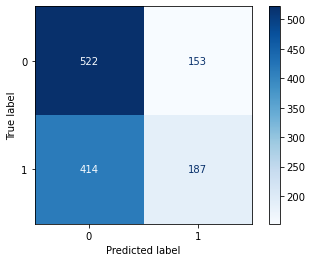

In [7]:
#checking variance and bias
print('Training Score:', vote.score(X_train_sc, y_train))
print('Testing Score:', vote.score(X_test_sc, y_test))

plot_confusion_matrix(vote, X_test_sc, y_test, cmap='Blues', 
                      values_format='d');

# Random Forest Classifier

In [8]:
rf = RandomForestClassifier(max_depth= 6, n_estimators = 50)
rf.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=6, n_estimators=50)

In [9]:
print('Training Score:', rf.score(X_train_sc, y_train))
print('Testing Score:', rf.score(X_test_sc, y_test))

Training Score: 0.5803921568627451
Testing Score: 0.5579937304075235


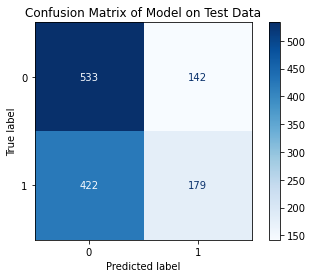

In [11]:
plot_confusion_matrix(rf, X_test_sc, y_test, cmap='Blues', 
                      values_format='d')
plt.title('Confusion Matrix of Model on Test Data');


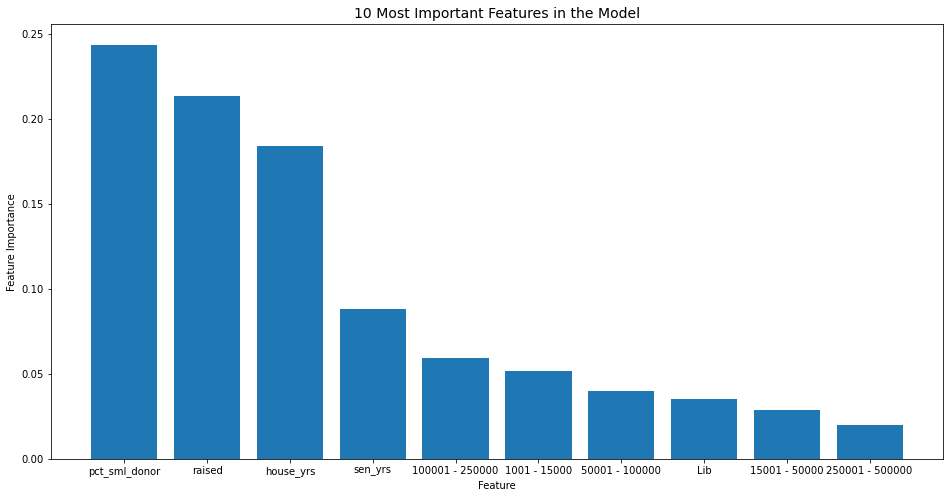

In [12]:
X.columns = ['sen_yrs', 'house_yrs', 'raised','pct_sml_donor','Ind', 'Rep', 'Lib', '- 1001','1001 - 15000',
             '100001 - 250000', '15001 - 50000', '250001 - 500000', '5000001 - 25000000',
            '50001 - 100000', '500001 - 1000000']
feature_imp = pd.DataFrame(data = rf.feature_importances_,index = X.columns,
             columns = ['feature importance']).sort_values('feature importance', ascending = False).head(10)

plt.figure(figsize = (16,8))
plt.bar(feature_imp.index, feature_imp['feature importance'])
plt.title('10 Most Important Features in the Model', fontsize = 14)
plt.ylabel('Feature Importance', fontsize = 10)
plt.xlabel('Feature', fontsize = 10);

**Interpretation**

The strongest predictors of whether a congressperson will beat the market on a trade it the amount of money they have raised campaigning, and the percentage of donations from small donors. The next strongest predictors are time spent in office, especially for members of the house.